In [1]:
import os

In [2]:
os.chdir('/content/drive/MyDrive/Project3')

In [3]:
import scipy.io as io
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

In [4]:
# 1. Load Data
trX = io.loadmat('SVHN_train_32x32.mat')['X']
trY = io.loadmat('SVHN_train_32x32.mat')['y']
tsX = io.loadmat('SVHN_test_32x32.mat')['X']
tsY = io.loadmat('SVHN_test_32x32.mat')['y']

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2a3208ccd0>,
 <matplotlib.image.AxesImage at 0x7f2a320130d0>)

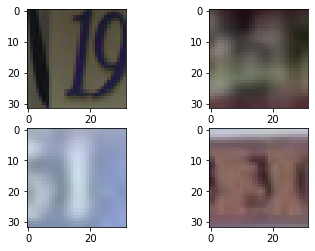

In [5]:
# Visualize few traiing images
plt.figure()
plt.subplot(221), plt.imshow(trX[0])
plt.subplot(222), plt.imshow(trX[255])
plt.subplot(223), plt.imshow(trX[645])
plt.subplot(224), plt.imshow(trX[2786])

In [6]:
# 2. Normalize and Encoding the labels using one-hot vector encoding.
# For images maximum value is 255, so we can easily normilize image data
# by dividing each pixel value by 255

trX = torch.from_numpy(trX/255.0).float()
tsX = torch.from_numpy(tsX/255.0).float()
trY = torch.from_numpy(trY).long()
tsY = torch.from_numpy(tsY).long()
trY = F.one_hot(trY).squeeze()
tsY = F.one_hot(tsY).squeeze()

In [7]:
import torch.nn as nn

In [8]:
# 3. Model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(128*1*1, 3072)
        self.fc2 = nn.Linear(3072, 2048)
        self.fc3 = nn.Linear(2048, 10)

    def forward(self, x):
        # Model as per project requirement
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x
net = Net()
if torch.cuda.is_available():
    net = net.cuda()

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [10]:
_, new_labels = trY.max(dim=-1)

In [11]:
from torch.utils.data import Dataset
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, img_data, labels):
      # From (batch_size, height, width, channel) to
      # to (batch_size, channel, height, width) as per crossentropy requirement
      self.img_data = img_data.permute(0, 3, 1, 2)
      _, self.labels = labels.max(dim=-1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.img_data[idx]
        label = self.labels[idx]
        mean, std = image.mean(), image.std()
        return image, label

In [12]:
training_data = CustomImageDataset(trX, trY)
test_data = CustomImageDataset(tsX, tsY)

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [14]:
print(f"Total parameter count of the network is: {sum(p.numel() for p in net.parameters() if p.requires_grad)}")

Total parameter count of the network is: 7022538


In [15]:
training_loss = []
testing_loss = []

In [16]:
# 4. Training and testing
# 20 epochs, 64 batch size and learning rate of 0.01
for epoch in range(20):
    net.train()
    train_loss = 0.0
    for inputs, labels in train_dataloader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    training_loss.append(train_loss/len(train_dataloader))
    print(f'Epoch #: {epoch} Training loss: {training_loss[-1]}')
    train_loss = 0.0

    # Use model in eval mode to get test validation error for the epoch
    net.eval()
    test_loss = 0.0
    for inputs, labels in test_dataloader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    testing_loss.append(test_loss/len(test_dataloader))
    print(f'Epoch #: {epoch} Testing loss: {testing_loss[-1]}')

print('Finished Training')

Epoch #: 0 Training loss: 2.2705063186878722
Epoch #: 0 Testing loss: 2.2615114125338467
Epoch #: 1 Training loss: 2.2646360965795393
Epoch #: 1 Testing loss: 2.244537267403755
Epoch #: 2 Training loss: 2.240594149260542
Epoch #: 2 Testing loss: 2.222876955894639
Epoch #: 3 Training loss: 2.2172273490106176
Epoch #: 3 Testing loss: 2.1645282562593278
Epoch #: 4 Training loss: 2.0423811522113184
Epoch #: 4 Testing loss: 1.8546946461722071
Epoch #: 5 Training loss: 1.589823594572242
Epoch #: 5 Testing loss: 1.263424589827254
Epoch #: 6 Training loss: 0.9861902918357516
Epoch #: 6 Testing loss: 0.8415011110411229
Epoch #: 7 Training loss: 0.743491046553616
Epoch #: 7 Testing loss: 0.7261635865421201
Epoch #: 8 Training loss: 0.6477588367514214
Epoch #: 8 Testing loss: 0.6764403728068021
Epoch #: 9 Training loss: 0.593968991577365
Epoch #: 9 Testing loss: 0.6410184194326987
Epoch #: 10 Training loss: 0.5577519727195714
Epoch #: 10 Testing loss: 0.6012728443456223
Epoch #: 11 Training loss:

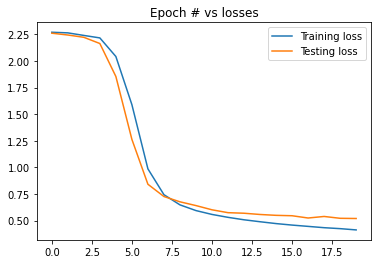

In [17]:
plt.plot(training_loss, label="Training loss")
plt.plot(testing_loss, label="Testing loss")
plt.legend()
plt.title("Epoch # vs losses")
plt.show()

In [18]:
# Prediction for accuracy
total = 0
correct = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [19]:
print(f'Accuracy of training data is: {(correct/total)*100}')

Accuracy of training data is: 87.96097111247695
